**Deep Learning Framework (Implement U-net)**

McMedHacks

**Understanding U-Net Architecture**  [Original paper](https://arxiv.org/pdf/1505.04597.pdf)

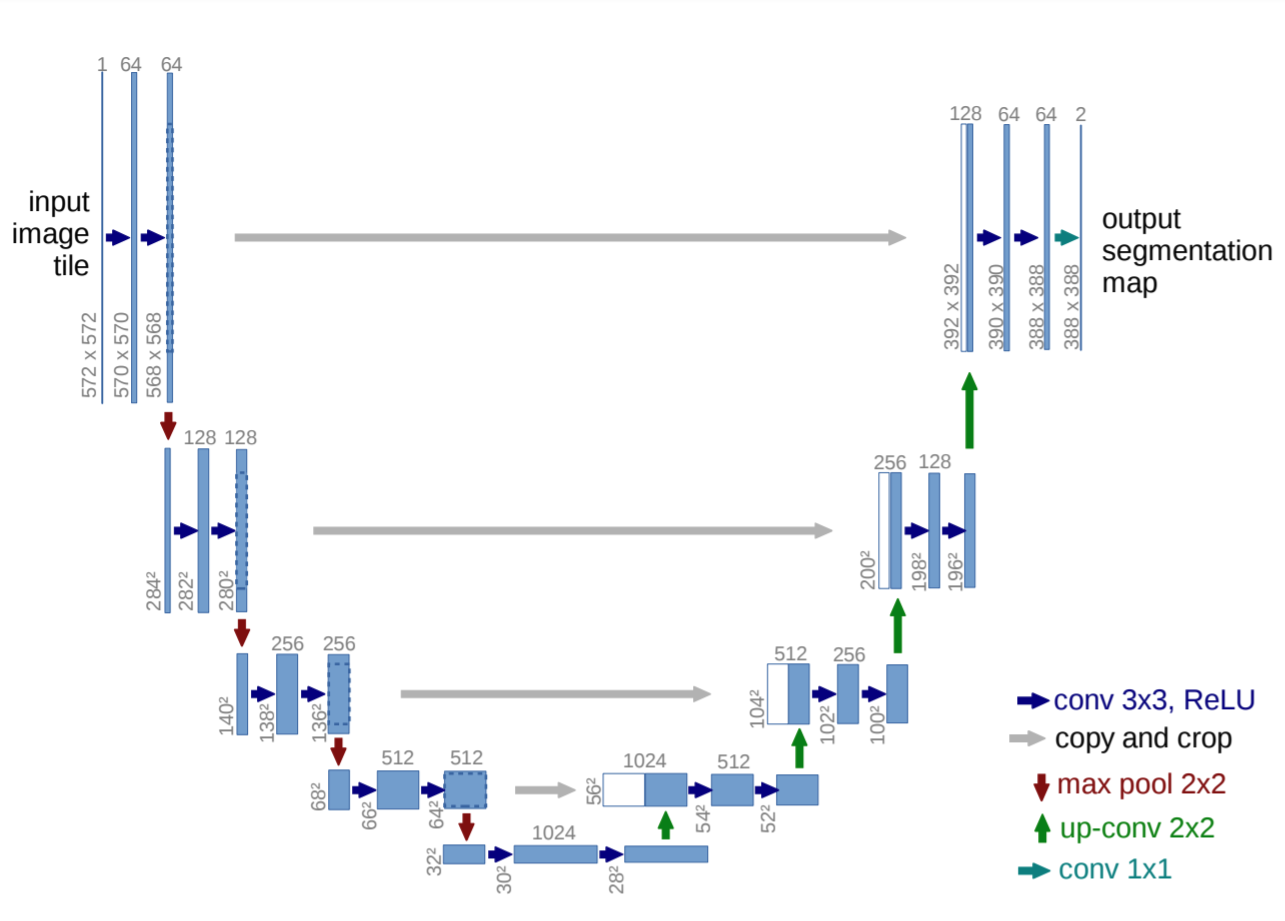

*   There are an encoder and decoder parts.
*   Max poolign 2*2 reduce size of image by half

Let's write one block

In [ ]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
!pip install MedPy
import numpy as np
from medpy.filter.binary import largest_connected_component
from skimage.exposure import rescale_intensity
from skimage.transform import resize


def dsc(y_pred, y_true, lcc=True):
    if lcc and np.any(y_pred):
        y_pred = np.round(y_pred).astype(int)
        y_true = np.round(y_true).astype(int)
        y_pred = largest_connected_component(y_pred)
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))


def crop_sample(x):
    volume, mask = x
    volume[volume < np.max(volume) * 0.1] = 0
    z_projection = np.max(np.max(np.max(volume, axis=-1), axis=-1), axis=-1)
    z_nonzero = np.nonzero(z_projection)
    z_min = np.min(z_nonzero)
    z_max = np.max(z_nonzero) + 1
    y_projection = np.max(np.max(np.max(volume, axis=0), axis=-1), axis=-1)
    y_nonzero = np.nonzero(y_projection)
    y_min = np.min(y_nonzero)
    y_max = np.max(y_nonzero) + 1
    x_projection = np.max(np.max(np.max(volume, axis=0), axis=0), axis=-1)
    x_nonzero = np.nonzero(x_projection)
    x_min = np.min(x_nonzero)
    x_max = np.max(x_nonzero) + 1
    return (
        volume[z_min:z_max, y_min:y_max, x_min:x_max],
        mask[z_min:z_max, y_min:y_max, x_min:x_max],
    )


def pad_sample(x):
    volume, mask = x
    a = volume.shape[1]
    b = volume.shape[2]
    if a == b:
        return volume, mask
    diff = (max(a, b) - min(a, b)) / 2.0
    if a > b:
        padding = ((0, 0), (0, 0), (int(np.floor(diff)), int(np.ceil(diff))))
    else:
        padding = ((0, 0), (int(np.floor(diff)), int(np.ceil(diff))), (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)
    return volume, mask


def resize_sample(x, size=256):
    volume, mask = x
    v_shape = volume.shape
    out_shape = (v_shape[0], size, size)
    mask = resize(
        mask,
        output_shape=out_shape,
        order=0,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    out_shape = out_shape + (v_shape[3],)
    volume = resize(
        volume,
        output_shape=out_shape,
        order=2,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    return volume, mask


def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99))
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume


def log_images(x, y_true, y_pred, channel=1):
    images = []
    x_np = x[:, channel].cpu().numpy()
    y_true_np = y_true[:, 0].cpu().numpy()
    y_pred_np = y_pred[:, 0].cpu().numpy()
    for i in range(x_np.shape[0]):
        image = gray2rgb(np.squeeze(x_np[i]))
        image = outline(image, y_pred_np[i], color=[255, 0, 0])
        image = outline(image, y_true_np[i], color=[0, 255, 0])
        images.append(image)
    return images


def gray2rgb(image):
    w, h = image.shape
    image += np.abs(np.min(image))
    image_max = np.abs(np.max(image))
    if image_max > 0:
        image /= image_max
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = image * 255
    return ret


def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 33.6 MB/s 
     |████████████████████████████████| 48.4 MB 1.6 MB/s 
  Created wheel for MedPy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754488 sha256=5c7a53672374f725520882d2b84d3a35f4cf52c4a435f8a480cc299d8d3984e6
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built MedPy


In [ ]:
import numpy as np
from skimage.transform import rescale, rotate
from torchvision.transforms import Compose


def transforms(scale=None, angle=None, flip_prob=None):
    transform_list = []

    if scale is not None:
        transform_list.append(Scale(scale))
    if angle is not None:
        transform_list.append(Rotate(angle))
    if flip_prob is not None:
        transform_list.append(HorizontalFlip(flip_prob))

    return Compose(transform_list)


class Scale(object):

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, mask = sample

        img_size = image.shape[0]

        scale = np.random.uniform(low=1.0 - self.scale, high=1.0 + self.scale)

        image = rescale(
            image,
            (scale, scale),
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )
        mask = rescale(
            mask,
            (scale, scale),
            order=0,
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )

        if scale < 1.0:
            diff = (img_size - image.shape[0]) / 2.0
            padding = ((int(np.floor(diff)), int(np.ceil(diff))),) * 2 + ((0, 0),)
            image = np.pad(image, padding, mode="constant", constant_values=0)
            mask = np.pad(mask, padding, mode="constant", constant_values=0)
        else:
            x_min = (image.shape[0] - img_size) // 2
            x_max = x_min + img_size
            image = image[x_min:x_max, x_min:x_max, ...]
            mask = mask[x_min:x_max, x_min:x_max, ...]

        return image, mask


class Rotate(object):

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, mask = sample

        angle = np.random.uniform(low=-self.angle, high=self.angle)
        image = rotate(image, angle, resize=False, preserve_range=True, mode="constant")
        mask = rotate(
            mask, angle, resize=False, order=0, preserve_range=True, mode="constant"
        )
        return image, mask


class HorizontalFlip(object):

    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, sample):
        image, mask = sample

        if np.random.rand() > self.flip_prob:
            return image, mask

        image = np.fliplr(image).copy()
        mask = np.fliplr(mask).copy()

        return image, mask

In [ ]:
import os
import random

import numpy as np
import torch
from skimage.io import imread
from torch.utils.data import Dataset


class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        validation_cases=10,
        seed=42,
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])
                print(f"{len(image_slices)} images read!")

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=validation_cases)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor

Please copy the data and the notebook to your drive and change the path in the datasets function below accordingly.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torch.utils.data import DataLoader

batch_size=2

def datasets():
    aug_scale = 0.05
    aug_angle =15
    image_size = 256
    # images= "/content/drive/MyDrive/Data_segmentation/kaggle_3m"
    ### Here write the name of the path you copied the data to
    images = "/content/drive/MyDrive/McMedHacks Workshop 2022 for participants/Week 6-1_Implement_U-Net/kaggle_3m"
    train = BrainSegmentationDataset(
        images_dir=images,
        subset="train",
        image_size=image_size,
        transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
    )
    valid = BrainSegmentationDataset(
        images_dir=images,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
    )
    return train, valid
def data_loaders():
    dataset_train, dataset_valid = datasets()

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=1,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=1,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

In [ ]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [ ]:

def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list

In [ ]:
import torch.optim as optim
from tqdm import tqdm


epochs= 100
vis_freq = 10
vis_images = 2
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

loader_train, loader_valid = data_loaders()
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
26 image read!
24 image read!
25 image read!
22 image read!
24 image read!
20 image read!
20 image read!
20 image read!
20 image read!
20 image read!
24 image read!
20 image read!
23 image read!
36 image read!
36 image read!
40 image read!
26 image read!
38 image read!
36 image read!
22 image read!
20 image read!
28 image read!
36 image read!
71 image read!
49 image read!
52 image read!
56 image read!
58 image read!
60 image read!
53 image read!
51 image read!
57 image read!
53 image read!
38 image read!
60 image read!
58 image read!
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
26 image read!
24 image read!
25 image read!
22 image read!
24 image read!
20 image read!
20 image read!
20 image read!
20 image read!
20 image read!
24 image read!
20 image read!
23 image read!
36 image read!
36 image read!
40 image read!
26

AttributeError: ignored

In [ ]:

unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(unet.parameters(), lr=0.001)

loss_train = []
loss_valid = []

step = 0

for epoch in tqdm(range(epochs), total=epochs):
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1

            x, y_true = data
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = unet(x)

                loss = dsc_loss(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )
                    if (epoch % vis_freq == 0) or (epoch == epochs - 1):
                        if i * batch_size < vis_images:
                            tag = "image/{}".format(i)
                            num_images = vis_images - i * batch_size

                if phase == "train":
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()

            if phase == "train" and (step + 1) % 10 == 0:
                print(f"step : {step}  ---  loss train : {loss_train}")
                loss_train = []

        if phase == "valid":
            print(f"step : {step}  ---  loss train : {loss_valid}")
            mean_dsc = np.mean(
                dsc_per_volume(
                    validation_pred,
                    validation_true,
                    loader_valid.dataset.patient_slice_index,
                )
            )
            print(f"step : {step}  ---  mean_dsc : {mean_dsc}")
            if mean_dsc > best_validation_dsc:
                best_validation_dsc = mean_dsc
                torch.save(unet.state_dict(), "unet.pt")
            loss_valid = []

print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

  0%|          | 0/100 [00:00<?, ?it/s]

step : 9  ---  loss train : [0.9485752582550049, 0.8822183609008789, 0.986813485622406, 0.9499821662902832, 0.9409418106079102, 0.8278796672821045, 0.8765856623649597, 0.8768494725227356, 0.8687744140625]
step : 19  ---  loss train : [0.8040692806243896, 0.9276217818260193, 0.8360174298286438, 0.8611055612564087, 0.9169609546661377, 0.8626937866210938, 0.9304288625717163, 0.7517061829566956, 0.8392825126647949, 0.8657299280166626]
step : 29  ---  loss train : [0.844277024269104, 0.7898597717285156, 0.7870556116104126, 0.9478707313537598, 0.8007240891456604, 0.8635917901992798, 0.9404151439666748, 0.8180797696113586, 0.9752345085144043, 0.8887588381767273]
step : 39  ---  loss train : [0.9512389898300171, 0.7373946905136108, 0.7916602492332458, 0.8063149452209473, 0.7851880788803101, 0.748427152633667, 0.8323068618774414, 0.8993020057678223, 0.7513787746429443, 0.7673826217651367]
step : 49  ---  loss train : [0.7874736785888672, 0.8388473391532898, 0.9490716457366943, 0.825768351554870

  1%|          | 1/100 [00:35<57:45, 35.00s/it]

step : 469  ---  mean_dsc : 0.4314098778493177
step : 479  ---  loss train : [0.2098659873008728, 0.1604621410369873, 0.7295231819152832, 0.16507524251937866, 0.405208945274353, 0.074582040309906, 0.11482274532318115, 0.21259182691574097, 0.44608384370803833, 0.20681673288345337]
step : 489  ---  loss train : [0.16065454483032227, 0.1690846085548401, 0.26829302310943604, 0.27989304065704346, 0.18842220306396484, 0.10672390460968018, 0.17615514993667603, 0.23823708295822144, 0.1001744270324707, 0.07148343324661255]
step : 499  ---  loss train : [0.1483413577079773, 0.38811928033828735, 0.47864198684692383, 0.11284422874450684, 0.15878069400787354, 0.28474634885787964, 0.07494205236434937, 0.5937433242797852, 0.0851169228553772, 0.33934420347213745]
step : 509  ---  loss train : [0.136601984500885, 0.211586594581604, 0.1673126220703125, 0.3566826581954956, 0.22775566577911377, 0.3156664967536926, 0.15606552362442017, 0.595569372177124, 0.26477599143981934, 0.18749642372131348]
step : 519

  2%|▏         | 2/100 [01:12<59:17, 36.30s/it]

step : 938  ---  mean_dsc : 0.48075319869814626
step : 939  ---  loss train : [0.11765921115875244, 0.22340816259384155, 0.2092563509941101, 0.3373778462409973, 0.19648075103759766, 0.08531689643859863, 0.1327853798866272, 0.08301186561584473, 0.1013537049293518, 0.1905841827392578]
step : 949  ---  loss train : [0.17062002420425415, 0.6886535882949829, 0.23510092496871948, 0.4442558288574219, 0.07993459701538086, 0.10016852617263794, 0.14330673217773438, 0.43585968017578125, 0.15321427583694458, 0.16449850797653198]
step : 959  ---  loss train : [0.08440285921096802, 0.2476251721382141, 0.2610575556755066, 0.15093928575515747, 0.06852912902832031, 0.14278936386108398, 0.2274254560470581, 0.10196691751480103, 0.0641283392906189, 0.14507299661636353]
step : 969  ---  loss train : [0.3922090530395508, 0.20794856548309326, 0.09896445274353027, 0.14898091554641724, 0.2853044867515564, 0.0637514591217041, 0.5452953577041626, 0.07135295867919922, 0.17967694997787476, 0.11814826726913452]
ste

  3%|▎         | 3/100 [01:50<59:54, 37.06s/it]

step : 1407  ---  mean_dsc : 0.5556239338719078
step : 1409  ---  loss train : [0.20147693157196045, 0.1798531413078308, 0.2910512089729309, 0.19014298915863037, 0.08162069320678711, 0.14092206954956055, 0.07956689596176147, 0.10551518201828003, 0.2120816707611084, 0.16628903150558472]
step : 1419  ---  loss train : [0.6732090711593628, 0.36184847354888916, 0.44252198934555054, 0.0788125991821289, 0.0938795804977417, 0.14664989709854126, 0.4122741222381592, 0.14803409576416016, 0.12838846445083618, 0.11132383346557617]
step : 1429  ---  loss train : [0.24753481149673462, 0.25076162815093994, 0.15251779556274414, 0.06042438745498657, 0.14441484212875366, 0.22168833017349243, 0.09996944665908813, 0.05855870246887207, 0.142974853515625, 0.3906858563423157]
step : 1439  ---  loss train : [0.19493108987808228, 0.09771382808685303, 0.12809687852859497, 0.19617575407028198, 0.06381040811538696, 0.36103183031082153, 0.06932574510574341, 0.11149686574935913, 0.08884501457214355, 0.1433365941047

  4%|▍         | 4/100 [02:26<58:38, 36.65s/it]

step : 1876  ---  mean_dsc : 0.557095640411165
step : 1879  ---  loss train : [0.16360175609588623, 0.3710933327674866, 0.15476852655410767, 0.08447545766830444, 0.14041835069656372, 0.07026427984237671, 0.05676257610321045, 0.15932798385620117, 0.140530526638031, 0.554228663444519]
step : 1889  ---  loss train : [0.08999359607696533, 0.33228516578674316, 0.07256442308425903, 0.10262399911880493, 0.15911966562271118, 0.43669265508651733, 0.14402973651885986, 0.1072232723236084, 0.07227945327758789, 0.2336968183517456]
step : 1899  ---  loss train : [0.24661898612976074, 0.1420118808746338, 0.0673016905784607, 0.11663448810577393, 0.21018940210342407, 0.07119178771972656, 0.06306195259094238, 0.13732314109802246, 0.3868824243545532, 0.1567232608795166]
step : 1909  ---  loss train : [0.09390133619308472, 0.13173407316207886, 0.2205195426940918, 0.06009566783905029, 0.36883753538131714, 0.06839621067047119, 0.10494530200958252, 0.07993191480636597, 0.13316959142684937, 0.0656737685203552

  5%|▌         | 5/100 [03:06<59:50, 37.80s/it]

step : 2349  ---  loss train : [0.37432295083999634, 0.16788744926452637, 0.08816182613372803, 0.12436985969543457, 0.07084107398986816, 0.06392055749893188, 0.13656115531921387, 0.13922357559204102, 0.5406440496444702, 0.12330174446105957]
step : 2359  ---  loss train : [0.28198814392089844, 0.0743861198425293, 0.09588617086410522, 0.1520981788635254, 0.4290447235107422, 0.1458139419555664, 0.11640065908432007, 0.09244745969772339, 0.24549990892410278, 0.2515227198600769]
step : 2369  ---  loss train : [0.13910621404647827, 0.06418824195861816, 0.11062633991241455, 0.2060578465461731, 0.08152395486831665, 0.06282168626785278, 0.13680720329284668, 0.38129526376724243, 0.15328449010849, 0.09525960683822632]
step : 2379  ---  loss train : [0.1258854866027832, 0.14702361822128296, 0.06057697534561157, 0.40678703784942627, 0.07052665948867798, 0.10222840309143066, 0.08566164970397949, 0.12700015306472778, 0.0690719485282898, 0.21364527940750122]
step : 2389  ---  loss train : [0.0500567555

  6%|▌         | 6/100 [03:48<1:01:53, 39.51s/it]

step : 2814  ---  mean_dsc : 0.5549297840745765
step : 2819  ---  loss train : [0.10339128971099854, 0.08336585760116577, 0.13323944807052612, 0.07374203205108643, 0.05740422010421753, 0.13908404111862183, 0.13651984930038452, 0.5836295485496521, 0.08863246440887451, 0.30761009454727173]
step : 2829  ---  loss train : [0.0717352032661438, 0.08408445119857788, 0.15303468704223633, 0.43266475200653076, 0.13958752155303955, 0.10488557815551758, 0.06065303087234497, 0.18294429779052734, 0.24728387594223022, 0.1343216896057129]
step : 2839  ---  loss train : [0.08484882116317749, 0.10261893272399902, 0.2007259726524353, 0.06267130374908447, 0.062330782413482666, 0.1337066888809204, 0.2804245352745056, 0.14563775062561035, 0.09409838914871216, 0.10895061492919922]
step : 2849  ---  loss train : [0.15752428770065308, 0.058249056339263916, 0.564915657043457, 0.06580054759979248, 0.09437501430511475, 0.07947772741317749, 0.13700872659683228, 0.06125360727310181, 0.24649441242218018, 0.061532735

  7%|▋         | 7/100 [04:27<1:00:54, 39.29s/it]

step : 3283  ---  mean_dsc : 0.5579723003746169
step : 3289  ---  loss train : [0.08328330516815186, 0.12288773059844971, 0.07489556074142456, 0.0598490834236145, 0.161699116230011, 0.1440960168838501, 0.5830332636833191, 0.10137432813644409, 0.29362720251083374, 0.07315021753311157]
step : 3299  ---  loss train : [0.08041960000991821, 0.1307564377784729, 0.4192010164260864, 0.13212847709655762, 0.116005539894104, 0.059983789920806885, 0.2044568657875061, 0.2479567527770996, 0.14766591787338257, 0.07090926170349121]
step : 3309  ---  loss train : [0.10431689023971558, 0.19175034761428833, 0.0722191333770752, 0.06041234731674194, 0.1348288655281067, 0.27004969120025635, 0.1443820595741272, 0.09612452983856201, 0.11440324783325195, 0.14789646863937378]
step : 3319  ---  loss train : [0.05797767639160156, 0.3290168046951294, 0.06845170259475708, 0.09898632764816284, 0.07964944839477539, 0.11327362060546875, 0.06090545654296875, 0.21162623167037964, 0.049372315406799316, 0.0951063632965087

  8%|▊         | 8/100 [05:05<59:43, 38.95s/it]  

step : 3752  ---  mean_dsc : 0.5613618919696173
step : 3759  ---  loss train : [0.10713213682174683, 0.07176685333251953, 0.08138704299926758, 0.12791234254837036, 0.16549479961395264, 0.5983749628067017, 0.1192319393157959, 0.2841978073120117, 0.07613807916641235, 0.06643480062484741]
step : 3769  ---  loss train : [0.12417727708816528, 0.3988167643547058, 0.1276523470878601, 0.13867700099945068, 0.06101316213607788, 0.2215442657470703, 0.24194860458374023, 0.1275271773338318, 0.06237834692001343, 0.13229155540466309]
step : 3779  ---  loss train : [0.25332480669021606, 0.06869077682495117, 0.058402299880981445, 0.12955254316329956, 0.3418431878089905, 0.14629876613616943, 0.09644860029220581, 0.10022860765457153, 0.15146994590759277, 0.05525892972946167]
step : 3789  ---  loss train : [0.4263172149658203, 0.07557672262191772, 0.08744120597839355, 0.0777100920677185, 0.13722705841064453, 0.07597017288208008, 0.27036166191101074, 0.06720763444900513, 0.29798221588134766, 0.104453086853

  9%|▉         | 9/100 [05:44<58:52, 38.82s/it]

step : 4221  ---  mean_dsc : 0.562417703205021
step : 4229  ---  loss train : [0.07980531454086304, 0.07715809345245361, 0.15331357717514038, 0.15619945526123047, 0.6141111850738525, 0.10715579986572266, 0.34865802526474, 0.07143527269363403, 0.06934010982513428, 0.13727563619613647]
step : 4239  ---  loss train : [0.3768531084060669, 0.13327956199645996, 0.10989606380462646, 0.05445301532745361, 0.16757291555404663, 0.24261802434921265, 0.12431806325912476, 0.06378263235092163, 0.0997040867805481, 0.2080489993095398]
step : 4249  ---  loss train : [0.06059688329696655, 0.05557382106781006, 0.13551479578018188, 0.27878105640411377, 0.14640694856643677, 0.10404950380325317, 0.056066691875457764, 0.14201492071151733, 0.05782032012939453, 0.3919954299926758]
step : 4259  ---  loss train : [0.06684446334838867, 0.09147608280181885, 0.07229936122894287, 0.12170076370239258, 0.06471043825149536, 0.211952805519104, 0.05367612838745117, 0.14662379026412964, 0.10268312692642212, 0.2881193757057

 10%|█         | 10/100 [06:24<59:01, 39.35s/it]

step : 4690  ---  mean_dsc : 0.5732860460261155
step : 4699  ---  loss train : [0.057138264179229736, 0.13883233070373535, 0.14814382791519165, 0.5835796594619751, 0.07413637638092041, 0.1759207844734192, 0.06371301412582397, 0.06426197290420532, 0.14431065320968628, 0.28346365690231323]
step : 4709  ---  loss train : [0.13282567262649536, 0.11199367046356201, 0.049914419651031494, 0.1473812460899353, 0.24744796752929688, 0.1338617205619812, 0.07062000036239624, 0.08912450075149536, 0.2031305432319641, 0.06095653772354126]
step : 4719  ---  loss train : [0.057652413845062256, 0.12596040964126587, 0.24019157886505127, 0.14140725135803223, 0.11049807071685791, 0.038349449634552, 0.14649361371994019, 0.06521892547607422, 0.34913575649261475, 0.07917147874832153]
step : 4729  ---  loss train : [0.08938765525817871, 0.06918621063232422, 0.10041064023971558, 0.05216032266616821, 0.20518255233764648, 0.04510796070098877, 0.1246904730796814, 0.1040802001953125, 0.21520918607711792, 0.070096433

 11%|█         | 11/100 [07:04<58:37, 39.52s/it]

step : 5159  ---  mean_dsc : 0.5742954408299654
step : 5169  ---  loss train : [0.10757732391357422, 0.14606207609176636, 0.5789338946342468, 0.07628530263900757, 0.186958909034729, 0.06637442111968994, 0.05649852752685547, 0.14110714197158813, 0.26305872201919556, 0.1260574460029602]
step : 5179  ---  loss train : [0.11778688430786133, 0.045152366161346436, 0.1319330334663391, 0.24389898777008057, 0.14732277393341064, 0.14635884761810303, 0.09110403060913086, 0.20083755254745483, 0.0554468035697937, 0.05617731809616089]
step : 5189  ---  loss train : [0.12511318922042847, 0.20200109481811523, 0.14088457822799683, 0.10675626993179321, 0.03585857152938843, 0.14063912630081177, 0.05928647518157959, 0.2918434143066406, 0.06286966800689697, 0.08942419290542603]
step : 5199  ---  loss train : [0.06247758865356445, 0.10099422931671143, 0.049897193908691406, 0.20177316665649414, 0.04259073734283447, 0.1102718710899353, 0.10550820827484131, 0.18589907884597778, 0.059158265590667725, 0.04852986

 12%|█▏        | 12/100 [07:53<1:02:08, 42.37s/it]

step : 5628  ---  mean_dsc : 0.5721120576438673
step : 5629  ---  loss train : [0.07112115621566772, 0.1915249228477478, 0.07060152292251587, 0.3080819249153137, 0.10023218393325806, 0.07902508974075317, 0.11954087018966675, 0.06764739751815796, 0.03773808479309082, 0.09993880987167358]
step : 5639  ---  loss train : [0.13155776262283325, 0.5213500261306763, 0.057972490787506104, 0.16870951652526855, 0.05825263261795044, 0.05231368541717529, 0.14994657039642334, 0.2433704137802124, 0.13193267583847046, 0.11073136329650879]
step : 5649  ---  loss train : [0.04500234127044678, 0.19457650184631348, 0.24162381887435913, 0.13716751337051392, 0.07140451669692993, 0.08669877052307129, 0.20726972818374634, 0.05262953042984009, 0.05582904815673828, 0.12716758251190186]
step : 5659  ---  loss train : [0.1916952133178711, 0.14128702878952026, 0.10882282257080078, 0.037650346755981445, 0.13758069276809692, 0.05744737386703491, 0.29026997089385986, 0.06342869997024536, 0.0947188138961792, 0.0667672

 13%|█▎        | 13/100 [08:30<58:44, 40.51s/it]  

step : 6097  ---  mean_dsc : 0.5788947575074548
step : 6099  ---  loss train : [0.1816157102584839, 0.05243009328842163, 0.29209959506988525, 0.12151885032653809, 0.07401430606842041, 0.13218480348587036, 0.06967836618423462, 0.0356939435005188, 0.10251933336257935, 0.1326255202293396]
step : 6109  ---  loss train : [0.47625917196273804, 0.05247765779495239, 0.17647546529769897, 0.05567556619644165, 0.05713391304016113, 0.15315508842468262, 0.25270354747772217, 0.1292310357093811, 0.1039419174194336, 0.07369327545166016]
step : 6119  ---  loss train : [0.20475202798843384, 0.25012069940567017, 0.14254224300384521, 0.06204402446746826, 0.08315032720565796, 0.20712530612945557, 0.05909550189971924, 0.05827301740646362, 0.12821674346923828, 0.20234155654907227]
step : 6129  ---  loss train : [0.14098197221755981, 0.10802340507507324, 0.06279915571212769, 0.13764792680740356, 0.06652671098709106, 0.28819817304611206, 0.06611400842666626, 0.08495676517486572, 0.06849569082260132, 0.08719158

 14%|█▍        | 14/100 [09:09<57:41, 40.25s/it]

step : 6566  ---  mean_dsc : 0.579592790559864
step : 6569  ---  loss train : [0.07389646768569946, 0.23246705532073975, 0.1540529727935791, 0.07269388437271118, 0.11370563507080078, 0.06535625457763672, 0.042446672916412354, 0.10072433948516846, 0.1365993618965149, 0.4990541338920593]
step : 6579  ---  loss train : [0.07967507839202881, 0.17971831560134888, 0.059004902839660645, 0.043572306632995605, 0.13923346996307373, 0.20630502700805664, 0.12795722484588623, 0.103457510471344, 0.0444449782371521, 0.18737566471099854]
step : 6589  ---  loss train : [0.2341090440750122, 0.14066839218139648, 0.0522083044052124, 0.0853877067565918, 0.21444159746170044, 0.04787415266036987, 0.05362296104431152, 0.12428438663482666, 0.1818954348564148, 0.14489775896072388]
step : 6599  ---  loss train : [0.11364775896072388, 0.039701998233795166, 0.14844197034835815, 0.055369019508361816, 0.25470399856567383, 0.06160002946853638, 0.10137736797332764, 0.07473975419998169, 0.08594423532485962, 0.053579211

 15%|█▌        | 15/100 [09:46<55:36, 39.25s/it]

step : 7035  ---  mean_dsc : 0.5867145991078058
step : 7039  ---  loss train : [0.3936939835548401, 0.08289170265197754, 0.0886772871017456, 0.11810052394866943, 0.06602579355239868, 0.043610572814941406, 0.10956060886383057, 0.14026254415512085, 0.4951654076576233, 0.05733388662338257]
step : 7049  ---  loss train : [0.1788729429244995, 0.06163632869720459, 0.04411214590072632, 0.13720488548278809, 0.184170663356781, 0.12564468383789062, 0.1069837212562561, 0.0404699444770813, 0.18828368186950684, 0.23354768753051758]
step : 7059  ---  loss train : [0.13987410068511963, 0.052322328090667725, 0.08219164609909058, 0.21526604890823364, 0.04668247699737549, 0.051937758922576904, 0.12018966674804688, 0.16488075256347656, 0.125444233417511, 0.10305815935134888]
step : 7069  ---  loss train : [0.03445780277252197, 0.12396562099456787, 0.05853307247161865, 0.2591465711593628, 0.05948007106781006, 0.09689593315124512, 0.06322884559631348, 0.08453381061553955, 0.05184483528137207, 0.19110310077

 16%|█▌        | 16/100 [10:22<53:36, 38.29s/it]

step : 7504  ---  mean_dsc : 0.5905844200438555
step : 7509  ---  loss train : [0.1679854393005371, 0.07146406173706055, 0.10810136795043945, 0.06217771768569946, 0.03508549928665161, 0.08942073583602905, 0.12375879287719727, 0.4861968755722046, 0.04164546728134155, 0.2480926513671875]
step : 7519  ---  loss train : [0.05345165729522705, 0.0552668571472168, 0.16577982902526855, 0.16710609197616577, 0.14182132482528687, 0.1094244122505188, 0.047946035861968994, 0.20825517177581787, 0.23248016834259033, 0.1299828290939331]
step : 7529  ---  loss train : [0.04533267021179199, 0.08553582429885864, 0.20418059825897217, 0.0447501540184021, 0.05189192295074463, 0.12078464031219482, 0.18986260890960693, 0.11983519792556763, 0.11804342269897461, 0.03768271207809448]
step : 7539  ---  loss train : [0.1325097680091858, 0.06215620040893555, 0.27416902780532837, 0.06175577640533447, 0.09019917249679565, 0.07467657327651978, 0.09066617488861084, 0.05323737859725952, 0.1811283826828003, 0.04243779182

 17%|█▋        | 17/100 [10:59<52:14, 37.77s/it]

step : 7973  ---  mean_dsc : 0.5890313768453838
step : 7979  ---  loss train : [0.07691341638565063, 0.10445475578308105, 0.07321548461914062, 0.04399311542510986, 0.09184938669204712, 0.12895488739013672, 0.6774420738220215, 0.05703097581863403, 0.3280991315841675, 0.05506491661071777]
step : 7989  ---  loss train : [0.04813253879547119, 0.16278237104415894, 0.18884408473968506, 0.14694660902023315, 0.11380922794342041, 0.053167641162872314, 0.2193731665611267, 0.23436576128005981, 0.14156121015548706, 0.042520999908447266]
step : 7999  ---  loss train : [0.0952216386795044, 0.20910733938217163, 0.04642075300216675, 0.05327242612838745, 0.12426841259002686, 0.1968303918838501, 0.11519908905029297, 0.10934257507324219, 0.03357964754104614, 0.12481170892715454]
step : 8009  ---  loss train : [0.05423218011856079, 0.28787195682525635, 0.06240648031234741, 0.0816192626953125, 0.06394165754318237, 0.07156723737716675, 0.05744868516921997, 0.17758262157440186, 0.04225355386734009, 0.1003019

 17%|█▋        | 17/100 [11:35<56:36, 40.92s/it]


ValueError: ignored

In [ ]:
from skimage.io import imsave
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

phase = "valid"
with torch.set_grad_enabled(False):
    unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
    state_dict = torch.load("unet.pt", map_location=device)
    unet.load_state_dict(state_dict)
    unet.eval()
    unet.to(device)

    input_list = []
    pred_list = []
    true_list = []

    for i, data in tqdm(enumerate(loaders[phase])):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)

        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])

def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

volumes = postprocess_per_volume(
    input_list,
    pred_list,
    true_list,
    loaders[phase].dataset.patient_slice_index,
    loaders[phase].dataset.patients,
)

def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true, lcc=False)
    return dsc_dict

dsc_dist = dsc_distribution(volumes)



def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

dsc_dist_plot = plot_dsc(dsc_dist)
imsave("./dsc.png", dsc_dist_plot)

for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0], color=[0, 255, 0])
        filename = "{}-{}.png".format(p, str(s).zfill(2))
        filepath = os.path.join("./predictions", filename)
        imsave(filepath, image)

152it [00:03, 44.85it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: ./predictions/TCGA_DU_5851_19950428-34.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: ./predictions/TCGA_DU_5872_19950223-66.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: ./predictions/TCGA_DU_6405_19851005-55.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: ./predictions/TCGA_DU_6405_19851005-56.png is a low contrast image


## References during the workshop

- [Workshop recording](https://www.youtube.com/watch?v=QDYqYyrdf7M&list=PLVH7T2_su-vkHLGQXJ0gHijbhjLJOCbaq&index=20)

- [Dataset from Kaggle used in this workshop: Brain MRI segmentation
Brain MRI images together with manual FLAIR abnormality segmentation masks](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

- [Original Unet paper 2015](https://arxiv.org/pdf/1505.04597.pdf)

- [Unet Classification and Loss Evaluation - Softmax and Cross Entropy Loss](https://deepnotes.io/softmax-crossentropy)
  - [Softmax classification with cross-entropy](https://peterroelants.github.io/posts/cross-entropy-softmax/)

- [Towards a guideline for evaluation metrics in medical image segmentation (reviews of evaluation metric definitions)](https://arxiv.org/ftp/arxiv/papers/2202/2202.05273.pdf)

- [Mask DINO: Towards a Unified Transformer-based framework for object detection and segmentation (most state-of-the-art detection algorithm Dr. Mohebbian mentioned)](https://arxiv.org/abs/2206.02777)

- Relating back to previous PyTorch Lightning workshop

  - [Using Optuna to optimize PyTorch lighting hyperparameters](https://www.pytorchlightning.ai/blog/using-optuna-to-optimize-pytorch-lightning-hyperparameters)

  - [Unet segmentation with `rising` and `Pytorch Lightning` Google Colab](https://colab.research.google.com/github/PhoenixDL/rising/blob/master/notebooks/lightning_segmentation.ipynb#scrollTo=9v04VKjPz6-c)

  - [Unet-PytochLightning: Kaggle challenge, attention Unet, very neat code!](https://www.kaggle.com/code/abhiswain/unet-pytorchlightning/notebook)
    - [Used data from Medical Segmentation Decathlon: generalisable 3D Semantic Segmentation, huge paper and public dataset from multimodalities and multi-institutions](http://medicaldecathlon.com/)
    - [paper](https://arxiv.org/pdf/2106.05735.pdf)

- [Peak Signal Noise Ratio (PSNR) example: post-processing smoothing method to improve model performance](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio)

- [A tutorial on how you can load and resume training your model in PyTorch (if you want to resume since we stopped early)](https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61)

- [Loss functions for image segmentation summary](https://github.com/JunMa11/SegLoss)




